In [1]:
import argparse
import time
import sys
import os
from pathlib import Path
import mlflow
import mlflow.pytorch
from sklearn.metrics import roc_auc_score
import numpy as np

# Add project root to path BEFORE importing from src
# project_root = Path(__file__).resolve().parents[1]
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

# Now import from src
import segmentation_models_pytorch as smp
import torch
import tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from src.data.datasets import BaseIberFireDataset


/Users/vladimir/ml-wildfire-prediction/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

Model configuration parameters:
- `MODEL_VERSION`: Version identifier of the trained model (e.g., "v9", "v10")
- `MODEL_ENCODER`: Encoder architecture used in the model (e.g., "resnet34", "resnet50")

Update these constants when testing different model versions or architectures.


In [20]:
# Model configuration
# Update this version number when evaluating different trained models
MODEL_VERSION = "v1"  # Current model version being evaluated
MODEL_ENCODER = "resnet50"  # Encoder architecture used

STATS_DIR = project_root / "stats"
TRAIN_STATS_PATH = STATS_DIR / "train_class_stats_is_fire.json"
# Construct model path from configuration
model_name = f"{MODEL_ENCODER}_{MODEL_VERSION}.pth"
model_path = project_root / "models" / model_name


In [4]:
# load model
# Setup
import sys
from pathlib import Path
import segmentation_models_pytorch as smp
import torch

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

ZARR_PATH = project_root / "data" / "gold" / "IberFire_coarse32.zarr"
from src.data.datasets import BaseIberFireDataset
from torch.utils.data import DataLoader

if True:
        feature_vars = [
            # Dynamic features (time-dependent)
            "FAPAR",
            "FWI",
            "LAI",
            "LST",
            "NDVI",
            "RH_max",
            "RH_mean",
            "RH_min",
            "RH_range",
            "SWI_001",
            "SWI_005",
            "SWI_010",
            "SWI_020",
            "is_holiday",
            #"is_near_fire",
            "surface_pressure_max",
            "surface_pressure_mean",
            "surface_pressure_min",
            "surface_pressure_range",
            "t2m_max",
            "t2m_mean",
            "t2m_min",
            "t2m_range",
            "total_precipitation_mean",
            "wind_direction_at_max_speed",
            "wind_direction_mean",
            "wind_speed_max",
            "wind_speed_mean",
            # CLC Level-3 classes (year-aware bases)
            "CLC_1",
            "CLC_2",
            "CLC_3",
            "CLC_4",
            "CLC_5",
            "CLC_6",
            "CLC_7",
            "CLC_8",
            "CLC_9",
            "CLC_10",
            "CLC_11",
            "CLC_12",
            "CLC_13",
            "CLC_14",
            "CLC_15",
            "CLC_16",
            "CLC_17",
            "CLC_18",
            "CLC_19",
            "CLC_20",
            "CLC_21",
            "CLC_22",
            "CLC_23",
            "CLC_24",
            "CLC_25",
            "CLC_26",
            "CLC_27",
            "CLC_28",
            "CLC_29",
            "CLC_30",
            "CLC_31",
            "CLC_32",
            "CLC_33",
            "CLC_34",
            "CLC_35",
            "CLC_36",
            "CLC_37",
            "CLC_38",
            "CLC_39",
            "CLC_40",
            "CLC_41",
            "CLC_42",
            "CLC_43",
            "CLC_44",
            # CLC aggregated proportions (year-aware bases)
            "CLC_agricultural_proportion",
            "CLC_arable_land_proportion",
            "CLC_artificial_proportion",
            "CLC_artificial_vegetation_proportion",
            "CLC_forest_and_semi_natural_proportion",
            "CLC_forest_proportion",
            "CLC_heterogeneous_agriculture_proportion",
            "CLC_industrial_proportion",
            "CLC_inland_waters_proportion",
            "CLC_inland_wetlands_proportion",
            "CLC_marine_waters_proportion",
            "CLC_maritime_wetlands_proportion",
            "CLC_mine_proportion",
            "CLC_open_space_proportion",
            "CLC_permanent_crops_proportion",
            "CLC_scrub_proportion",
            "CLC_urban_fabric_proportion",
            "CLC_waterbody_proportion",
            "CLC_wetlands_proportion",
            # Other static features
            "aspect_1",
            "aspect_2",
            "aspect_3",
            "aspect_4",
            "aspect_5",
            "aspect_6",
            "aspect_7",
            "aspect_8",
            "aspect_NODATA",
            "dist_to_railways_mean",
            "dist_to_railways_stdev",
            "dist_to_roads_mean",
            "dist_to_roads_stdev",
            "dist_to_waterways_mean",
            "dist_to_waterways_stdev",
            "elevation_mean",
            "elevation_stdev",
            "is_natura2000",
            "is_sea",
            "is_spain",
            "is_waterbody",
            "roughness_mean",
            "roughness_stdev",
            "slope_mean",
            "slope_stdev",
            # Year-aware population density (popdens_YYYY family)
            "popdens",
        ]

in_channels = len(feature_vars)

####

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = smp.Unet(
    encoder_name=MODEL_ENCODER,
    encoder_weights=None,        
    in_channels=in_channels,
    classes=1,
    activation=None,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Load the checkpoint (new format: state dict only, no epoch/optimizer info)
checkpoint = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint)



<All keys matched successfully>

Loaded model output shape: torch.Size([1, 1, 28, 37])


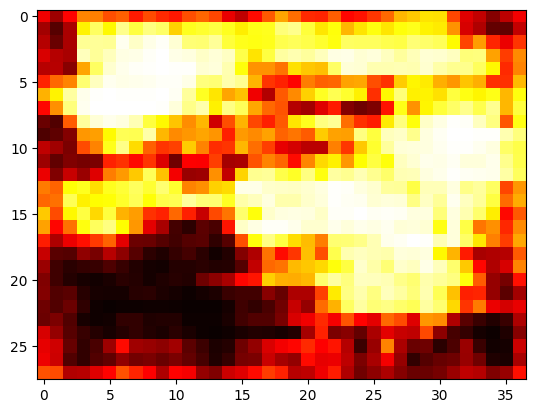

In [5]:
import matplotlib.pyplot as plt
test_ds = BaseIberFireDataset(
    zarr_path=ZARR_PATH,
    time_start="2008-01-01",
    time_end="2024-12-31",
    feature_vars=feature_vars,
    label_var="is_fire",
    lead_time=1,
    compute_stats=False,
    stats_path=project_root / "stats" / "simple_iberfire_stats_train.json"
)
X, y = test_ds[0]
X = X.unsqueeze(0).to(device).float()
model.eval()
with torch.no_grad():
    out = model(X)
    probs = torch.sigmoid(out).cpu().numpy()
image = probs[0, 0, :, :]
plt.imshow(image, cmap="hot")
print("Loaded model output shape:", out.shape)

In [21]:
import json
import math
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt


def compare_prediction(
    model,
    ds,
    date_str: str,
    device: torch.device = torch.device("mps"),
    stats_path: str | Path = TRAIN_STATS_PATH,
):
    """Visualize prediction vs GT for a given date, using logit adjustment derived from class stats."""

    # Find sample index for the requested date
    idxs = [i for i in range(len(ds)) if str(ds.get_time_value(i))[:10] == date_str]
    if not idxs:
        print(f"No sample found for date {date_str}")
        return
    idx = idxs[0]

    # Get data
    X, y = ds[idx]   # X: [C,H,W], y: [1,H,W]

    # GT stats
    fire_count = int(y.sum().item())
    fire_ratio = float(y.mean().item())

    # Load class stats to reconstruct logit adjustment
    stats_path = Path(stats_path)
    with stats_path.open("r") as f:
        stats = json.load(f)
    pi_pos = float(stats["pos_ratio"])
    pi_neg = float(stats["neg_ratio"])
    logit_adjustment = math.log(max(pi_pos, 1e-12) / max(pi_neg, 1e-12))

    # Predict
    model.eval()
    with torch.no_grad():
        logits = model(X.unsqueeze(0).to(device).float())
        # Apply the same logit adjustment used in training
        logits_adj = logits + logit_adjustment
        probs = torch.sigmoid(logits_adj).cpu().squeeze().numpy()  # [H,W]

    # Binary masks
    target = y.squeeze().numpy()             # [H,W]
    gt_mask = (target > 0.5).astype(float)   # GT fires
    pred_mask = (probs >= 0.5).astype(float) # predicted fires (after adjustment)

    pred_fire_count = int(pred_mask.sum())

    # Plot prediction + bright GT overlay
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    # Probability heatmap in background
    vmin, vmax = np.percentile(probs, [1, 99])
    im_pred = ax.imshow(
        probs,
        cmap="Reds",
        vmin=vmin,
        vmax=vmax,
        origin="lower",
        zorder=0,
    )
    cbar = plt.colorbar(im_pred, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Adjusted predicted probability")

    # Bright BLUE overlay for true fire pixels (GT)
    gt_masked = np.ma.masked_where(gt_mask == 0, gt_mask)
    ax.imshow(
        gt_masked,
        cmap="Blues",   # bright blue
        alpha=0.9,      # very visible
        origin="lower",
        zorder=2,
        vmin=0,
        vmax=1,
    )

    # Optional: green overlay for predicted fire pixels
    pred_masked = np.ma.masked_where(pred_mask == 0, pred_mask)
    ax.imshow(
        pred_masked,
        cmap="Greens",
        alpha=0.4,
        origin="lower",
        zorder=1,
        vmin=0,
        vmax=1,
    )

    ax.set_title(
        f"{date_str} (idx={idx})\n"
        f"GT fire cells={fire_count} (ratio={fire_ratio:.3e}) | "
        f"Pred fire cells={pred_fire_count}"
    )
    ax.axis("off")
    plt.tight_layout()
    plt.show()

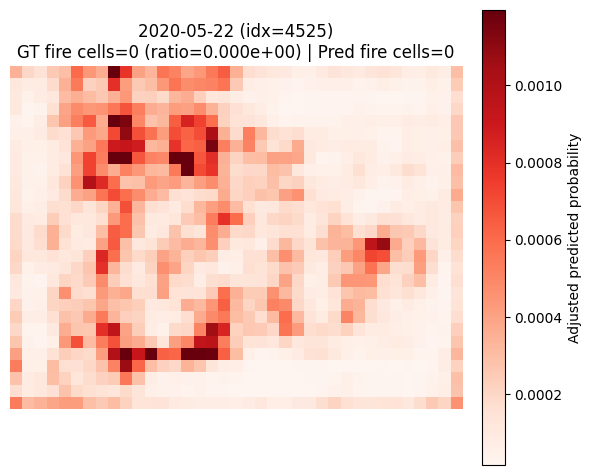

In [22]:
compare_prediction(model, test_ds, "2020-05-22")

In [28]:
idx1, idx2 = 976, 2635
ds = test_ds
X1, y1 = ds[idx1]
X2, y2 = ds[idx2]

print("date1:", ds.get_time_value(idx1), "date2:", ds.get_time_value(idx2))

print("X mean/std/min/max #1:", float(X1.mean()), float(X1.std()), float(X1.min()), float(X1.max()))
print("X mean/std/min/max #2:", float(X2.mean()), float(X2.std()), float(X2.min()), float(X2.max()))

print("X mean abs diff:", float((X1 - X2).abs().mean()))
print("X max abs diff:", float((X1 - X2).abs().max()))
print("X allclose:", torch.allclose(X1, X2, atol=1e-6))

# per-channel change (top 10 channels that actually differ)
per_ch = (X1 - X2).abs().mean(dim=(1,2))
vals, inds = torch.topk(per_ch, k=min(10, per_ch.numel()))
print("top changing channels:", inds.tolist())
print("their mean abs diffs:", vals.tolist())

date1: 2010-09-03T00:00:00.000000000 date2: 2015-03-20T00:00:00.000000000
X mean/std/min/max #1: -0.018228070810437202 0.9513647556304932 -3.4389023780822754 42.11089324951172
X mean/std/min/max #2: -0.031060069799423218 0.9661763310432434 -15.619613647460938 26.874969482421875
X mean abs diff: 0.19841434061527252
X max abs diff: 42.09421157836914
X allclose: False
top changing channels: [26, 18, 3, 19, 25, 8, 20, 23, 24, 7]
their mean abs diffs: [1.2672371864318848, 1.2351428270339966, 1.2055987119674683, 1.1986935138702393, 1.1711663007736206, 1.135042667388916, 1.034598469734192, 0.9108796715736389, 0.9038518071174622, 0.8727924227714539]


In [29]:
model.eval()
with torch.no_grad():
    p1 = torch.sigmoid(model(X1.unsqueeze(0).to(device).float())).cpu()[0,0]
    p2 = torch.sigmoid(model(X2.unsqueeze(0).to(device).float())).cpu()[0,0]

print("pred mean/std #1:", float(p1.mean()), float(p1.std()))
print("pred mean/std #2:", float(p2.mean()), float(p2.std()))
print("pred mean abs diff:", float((p1 - p2).abs().mean()))
print("pred max abs diff:", float((p1 - p2).abs().max()))
print("pred corr:", float(np.corrcoef(p1.flatten(), p2.flatten())[0,1]))

pred mean/std #1: 0.0628633126616478 0.18865513801574707
pred mean/std #2: 0.07634786516427994 0.18168410658836365
pred mean abs diff: 0.036630455404520035
pred max abs diff: 0.5875239968299866
pred corr: 0.9075391634819913


In [14]:
nan_per_ch = torch.isnan(X1).any(dim=(1,2))
nan_channels = nan_per_ch.nonzero(as_tuple=False).squeeze(1).tolist()
print("Channels with NaNs:", nan_channels)
print("Num channels with NaNs:", len(nan_channels), "out of", X1.shape[0])

Channels with NaNs: []
Num channels with NaNs: 0 out of 116
